In [2]:
import argparse
import numpy as np
import random
import torch
import os

import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Subset, DataLoader

from transformers import AdamW, get_linear_schedule_with_warmup
from typing import List
import time
from accelerate import Accelerator
from accelerate import DistributedDataParallelKwargs

from watchog.dataset import TableDataset, SupCLTableDataset
from watchog.model import SupCLforTable, UnsupCLforTable, SupclLoss
import wandb

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import torch
import seaborn as sns

In [3]:
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str, default="Watchog") # simclr for original CL, supcon for CL using metadata
    parser.add_argument("--pretrain_data", type=str, default="wikitables") # dataset for pretraining
    parser.add_argument("--pretrained_model_path", type=str, default="") # pretrained checkpoint 
    parser.add_argument("--data_path",type=str, default="/data/zhihao/TU/TURL/")
    parser.add_argument("--mode", type=str, default="simclr") # simclr for original CL, supcon for CL using metadata
    parser.add_argument("--logdir", type=str, default="/data/zhihao/TU/Watchog/model/") # directory to store model checkpoints
    parser.add_argument("--run_id", type=int, default=0)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--max_len", type=int, default=128)
    parser.add_argument("--size", type=int, default=10000)
    parser.add_argument("--lr", type=float, default=5e-5)
    parser.add_argument("--n_epochs", type=int, default=20)
    parser.add_argument("--lm", type=str, default='bert')
    parser.add_argument("--projector", type=int, default=768)
    parser.add_argument("--augment_op", type=str, default='sample_row4,sample_row4')
    parser.add_argument("--table_order", type=str, default='column')
    parser.add_argument("--sample_meth", type=str, default='tfidf_entity')
    parser.add_argument("--temperature", type=float, default=0.05)
    parser.add_argument("--save_model", type=int, default=5)
    parser.add_argument("--fp16", dest="fp16", default=True, action="store_true")
    parser.add_argument("--gpus", type=str, default="0")
    parser.add_argument("--single_column", default=False)
    
    hp = parser.parse_args([])

In [4]:
df_train.sample(0)

NameError: name 'df_train' is not defined

In [5]:
tokenizer = BertTokenizer.from_pretrained(shortcut_name)

NameError: name 'BertTokenizer' is not defined

In [6]:
path = hp.data_path + '/train_tables.jsonl'
trainset = TableDataset.from_hp(path, hp)

In [10]:
trainset.load_from_wikitables(path)

Number of tables:  10000


In [16]:
len(trainset[0])

3

In [18]:
x_ori, x_aug, cls_indices = trainset[0]

In [20]:
trainset.pad

<bound method TableDataset.pad of <watchog.dataset.TableDataset object at 0x7fcaccef0d00>>

In [21]:
    padder = trainset.pad
    # create the DataLoaders
    train_iter = data.DataLoader(dataset=trainset, shuffle=True,
                                 batch_size=hp.batch_size,
                                 collate_fn=padder)

In [23]:
for data in train_iter:
    x_ori, x_aug, cls_indices = data
    break

In [27]:
model = UnsupCLforTable(hp, lm=hp.lm)

# Ontology

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import torch
import seaborn as sns

In [46]:
import glob
table_names = glob.glob('/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/*')

In [135]:
len(table_names)

6892

In [73]:
import glob
table_names_21 = glob.glob('/data/zhihao/TU/GitTables/semtab_gittables/2021/tables/*')

In [75]:
set(table_names_21).intersection(set(table_names))

set()

In [74]:
len(table_names_21)

1101

In [48]:
len(table_names)

6892

In [9]:
import pickle
dbpedia_ontology = pickle.load(open("/data/zhihao/TU/GitTables/dbpedia_20210528.pkl", 'rb'))
schema_ontology = pickle.load(open("/data/zhihao/TU/GitTables/schema_20210528.pkl", 'rb'))

In [101]:
df_table = pd.read_csv('/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/GitTables_2727.csv')

In [103]:
df_table = pd.read_csv('/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/GitTables_6415.csv')

In [104]:
df_table

,col0,col1,col2,col3
0,2990001,2250001,2070001,V1
1,2990002,2250001,2070002,V2
2,2990003,2250001,2070003,V3
3,2990004,2250001,2070005,V4
4,2990005,2250001,2070004,V4
5,2990006,2250001,2070010,V3
6,2990007,2250001,2070006,V5
7,2990008,2250001,2070007,V5
8,2990009,2250001,2070008,V5
9,2990011,2250001,2070012,V0


In [15]:
df_target_train = pd.read_csv("/data/zhihao/TU/GitTables/semtab_gittables/2022/dbpedia_property_train.csv")
df_target_test = pd.read_csv("/data/zhihao/TU/GitTables/semtab_gittables/2022/dbpedia_property_targets.csv")
df_gt_2021 = pd.read_csv("/data/zhihao/TU/GitTables/semtab_gittables/2021/dbpedia_gt.csv")
df_target_2021 = pd.read_csv("/data/zhihao/TU/GitTables/semtab_gittables/2021/dbpedia_targets.csv")

In [3]:

from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)

In [14]:
index = np.arange(len(df_target_train))
labels = np.array([t.split("/")[-1] for t in df_target_train["annotation_id"].values])
table_ids = np.array([int(t.split("_")[-1]) for t in df_target_train["table_id"].values])

In [20]:
df_target_train[df_target_train["table_id"] == "GitTables_102063"]

,table_id,target_column,annotation_id
3435,GitTables_102063,20,http://dbpedia.org/ontology/type
5767,GitTables_102063,6,http://dbpedia.org/ontology/time


In [17]:
102063 in table_ids

True

In [21]:
1246*2+1245*3

6227

In [36]:
sgkf = StratifiedGroupKFold(n_splits=5)
sgkf.get_n_splits(index, labels)
train_index_list = []
test_index_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(index, labels, table_ids)):
    train_index_list.append(train_index)
    test_index_list.append(test_index)
    print("TRAIN:", i, len(train_index), "TEST:", len(test_index), len(set(table_ids[train_index]).intersection(set(table_ids[test_index]))))

TRAIN: 0 4981 TEST: 1246 0
TRAIN: 1 4981 TEST: 1246 0
TRAIN: 2 4982 TEST: 1245 0
TRAIN: 3 4982 TEST: 1245 0
TRAIN: 4 4982 TEST: 1245 0


In [73]:
print(train_index_list)

[array([   1,    2,    5, ..., 6223, 6224, 6225]), array([   0,    1,    2, ..., 6224, 6225, 6226]), array([   0,    1,    3, ..., 6223, 6224, 6226]), array([   0,    1,    2, ..., 6224, 6225, 6226]), array([   0,    2,    3, ..., 6222, 6225, 6226])]


In [76]:
print(train_index_list)

[array([   1,    2,    5, ..., 6223, 6224, 6225]), array([   0,    1,    2, ..., 6224, 6225, 6226]), array([   0,    1,    3, ..., 6223, 6224, 6226]), array([   0,    1,    2, ..., 6224, 6225, 6226]), array([   0,    2,    3, ..., 6222, 6225, 6226])]


In [125]:
# check whether index in two different folds are the same

for i in range(5):
    for j in range(5):
        # print(i, j, len(set(test_index_list[i]).intersection(set(train_index_list[j]))))
        # print(i, j, len(set(test_index_list[i]).intersection(set(test_index_list[j]))))
        print(i, j, len(set(table_ids[test_index_list[i]]).intersection(set(table_ids[test_index_list[j]]))))

0 0 819
0 1 0
0 2 0
0 3 0
0 4 0
1 0 0
1 1 822
1 2 0
1 3 0
1 4 0
2 0 0
2 1 0
2 2 818
2 3 0
2 4 0
3 0 0
3 1 0
3 2 0
3 3 817
3 4 0
4 0 0
4 1 0
4 2 0
4 3 0
4 4 821


In [137]:
tables_num = 0
for i in range(5):
    print(len(set(table_ids[test_index_list[i]])))
    tables_num += len(set(table_ids[test_index_list[i]]))

819
822
818
817
821


In [138]:
tables_num

4097

In [136]:
len(table_names)

6892

In [148]:
table_id

'GitTables_100277'

In [151]:
table_df.columns[0]

'col0'

In [166]:
df

,table_id,col_idx,class,class_id,data
0,GitTables_100277,0,id,0,state_id_0 state_id_1 state_id_2 state_id_3 st...
1,GitTables_100277,1,name,1,Alytaus apskritis Kauno apskritis Klaipėdos ap...
2,GitTables_100277,2,NaN,-1,A K L M P S J T U V
3,GitTables_100277,3,NaN,-1,base.lt base.lt base.lt base.lt base.lt base.l...
4,GitTables_100850,0,NaN,-1,A1234582 13 A1234624 A1234595 A1234578 A123460...
...,...,...,...,...,...
10137,GitTables_99850,15,NaN,-1,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -10.0 ...
10138,GitTables_99850,16,NaN,-1,rpm Nm rpm rpm KW KW W
10139,GitTables_99885,0,id,0,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
10140,GitTables_99885,1,NaN,-1,1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 ...


In [7]:
import os
base_dirpath= "/data/zhihao/TU/GitTables/semtab_gittables/2022"
basename = 'comma'+ "_cv_{}.csv"
df_list = []
for i in range(5):
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_full = pd.concat(df_list, axis=0)

In [ ]:
import os
base_dirpath= "/data/zhihao/TU/GitTables/semtab_gittables/2022"
basename = 'blank'+ "_cv_{}.csv"
df_list = []
for i in range(5):
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_full = pd.concat(df_list, axis=0)

In [202]:
(df_full["class_id"] > -1).sum()

5794

In [208]:
1-5794/50026

0.8841802262823332

In [210]:
df_full

,table_id,col_idx,class,class_id,data
0,GitTables_100277,0,id,0,"state_id_0,state_id_1,state_id_2,state_id_3,st..."
1,GitTables_100277,1,name,1,"Alytaus apskritis,Kauno apskritis,Klaipėdos ap..."
2,GitTables_100277,2,NaN,-1,"A,K,L,M,P,S,J,T,U,V"
3,GitTables_100277,3,NaN,-1,"base.lt,base.lt,base.lt,base.lt,base.lt,base.l..."
4,GitTables_100850,0,NaN,-1,"A1234582,13,A1234624,A1234595,A1234578,A123460..."
...,...,...,...,...,...
10089,GitTables_99936,4,NaN,-1,"2340,2469,2703,1996,1967,2519,2583,1976,2341,2..."
10090,GitTables_99936,5,NaN,-1,"11/09/18,11/09/18,11/09/18,11/09/18,11/09/18,1..."
10091,GitTables_99936,6,price,24,"2005.5,929.99,358.99,649.99,248.99,253.11,354...."
10092,GitTables_99936,7,NaN,-1,"11/15/18,11/15/18,11/15/18,11/15/18,11/15/18,1..."


In [192]:
df = pd.read_csv(f"/data/zhihao/TU/GitTables/semtab_gittables/2022/blank_cv_{1}.csv")

193


<Axes: ylabel='Count'>

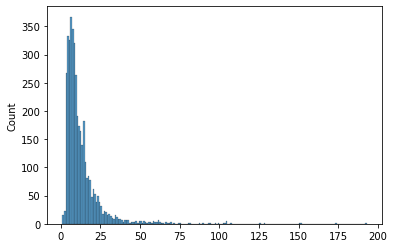

In [205]:
df_group = df_full.groupby("table_id")
column_num = []
for i, (index, group_df) in enumerate(df_group):
    column_num.append(len(group_df))
print(max(column_num))
sns.histplot(column_num)

7


<Axes: ylabel='Count'>

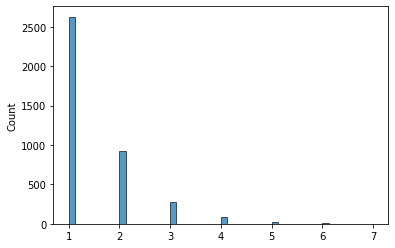

In [207]:

df_group = df_full.groupby("table_id")
column_num = []
for i, (index, group_df) in enumerate(df_group):
    group_df = group_df[group_df["class_id"] > -1]
    if len(group_df) == 0:
        continue
    column_num.append(len(group_df))
print(max(column_num))
sns.histplot(column_num) # TODO: why there is zero

In [182]:
df["class_id"].value_counts().sort_index()

-1      8979
 0       264
 1       146
 2        63
 3        53
        ... 
 96        1
 97        2
 98        1
 99        1
 100       1
Name: class_id, Length: 102, dtype: int64

In [189]:
df["class_id"].value_counts().sort_index()

-1      9098
 0       262
 1       146
 2        60
 3        52
        ... 
 96        1
 97        2
 98        2
 99        2
 100       2
Name: class_id, Length: 102, dtype: int64

In [185]:
len(types)

101

0.8853283376059948


<Axes: >

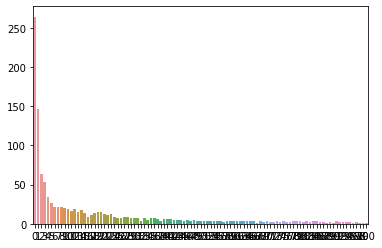

In [184]:
class_samples = df["class_id"].value_counts().sort_index().values[1:]
print(df["class_id"].value_counts().sort_index().values[0]/sum(df["class_id"].value_counts().sort_index().values))
sns.barplot(x=np.arange(len(class_samples)), y=class_samples)

In [38]:
test_index_list

[array([   0,    3,    4, ..., 6210, 6211, 6226]),
 array([   9,   22,   27, ..., 6212, 6218, 6220]),
 array([   2,   12,   17, ..., 6217, 6222, 6225]),
 array([   7,    8,   10, ..., 6214, 6215, 6216]),
 array([   1,    5,    6, ..., 6221, 6223, 6224])]

In [39]:
df_test

,table_id,col_idx,class,class_id,data
0,GitTables_100277,0,id,0,state_id_0;state_id_1;state_id_2;state_id_3;st...
1,GitTables_100277,1,name,1,Alytaus apskritis;Kauno apskritis;Klaipėdos ap...
2,GitTables_100277,2,NaN,-1,A;K;L;M;P;S;J;T;U;V
3,GitTables_100277,3,NaN,-1,base.lt;base.lt;base.lt;base.lt;base.lt;base.l...
4,GitTables_100850,0,NaN,-1,A1234582;13;A1234624;A1234595;A1234578;A123460...
...,...,...,...,...,...
10137,GitTables_99850,15,NaN,-1,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;-10.0;...
10138,GitTables_99850,16,NaN,-1,rpm;Nm;rpm;rpm;KW;KW;W
10139,GitTables_99885,0,id,0,1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
10140,GitTables_99885,1,NaN,-1,1;1;1;1;1;1;1;1;1;1;1;1;1;1;3;3;3;3;3;3;3;3;3;...


In [42]:
group

,table_id,target_column,annotation_id
606,GitTables_83729,0,http://dbpedia.org/ontology/id


In [43]:
table_id

'GitTables_83729'

In [ ]:
# TODO: clean invalid tables

In [45]:
type2id["NaN"] = -1
id2type[-1] = "NaN"
null_table = []
for cv in range(5):
    test_index = test_index_list[cv]
    fold_df = df_target_train.iloc[test_index]
    fold_group = fold_df.groupby("table_id")
    data_list = []
    for table_id, group in fold_group:
        table_df = pd.read_csv(f"/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/{table_id}.csv")
        target_column = group["target_column"].values.tolist()
        target_label = [t.split("/")[-1] for t in group["annotation_id"].values]
        if len(table_df.iloc[:, target_column].dropna()) == 0:
            null_table.append(table_id)
            continue # skip tables without target columns
        for i in range(len(table_df.columns)):
            if len(table_df.iloc[:, i].dropna()) > 0:
                # At least one non-NaN data should be there
                label = target_label[target_column.index(i)] if i in target_column else "NaN"
                class_id = type2id[label]
                data_list.append([table_id,
                                    i,
                                    label,
                                    class_id,
                                    " ".join([str(x) for x in table_df.iloc[:, i].dropna().tolist()])])
    df = pd.DataFrame(data_list, columns=["table_id", "col_idx", "class", "class_id", "data"])
    df.to_csv("/data/zhihao/TU/GitTables/semtab_gittables/2022/blank_cv_{}.csv".format(cv), index=False)
        

GitTables_102063


In [57]:

base_dirpath = "/data/zhihao/TU/GitTables/semtab_gittables/2022/"
seperator = "blank"
basename = seperator+"_cv_{}.csv"
df_list = []
for i in range(5):
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_cv = pd.read_csv(filepath)
    print(i, df_cv["table_id"].unique().shape[0], len(df_cv[df_cv["class_id"]>-1]), df_cv[df_cv["class_id"]>-1]["class_id"].unique().shape[0])

0 750 1085 101
1 755 1110 101
2 746 1091 101
3 745 1078 99
4 741 1069 99


In [46]:
len(null_table)

360

In [169]:
type2id["NaN"] = -1
id2type[-1] = "NaN"
null_table = []
for cv in range(5):
    test_index = test_index_list[cv]
    fold_df = df_target_train.iloc[test_index]
    fold_group = fold_df.groupby("table_id")
    data_list = []
    for table_id, group in fold_group:
        table_df = pd.read_csv(f"/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/{table_id}.csv")
        target_column = group["target_column"].values.tolist()
        target_label = [t.split("/")[-1] for t in group["annotation_id"].values]
        if len(table_df.iloc[:, target_column].dropna()) == 0:
            null_table.append(table_id)
            continue # skip tables without target columns
        for i in range(len(table_df.columns)):
            if len(table_df.iloc[:, i].dropna()) > 0:
                # At least one non-NaN data should be there
                label = target_label[target_column.index(i)] if i in target_column else "NaN"
                class_id = type2id[label]
                data_list.append([table_id,
                                    i,
                                    label,
                                    class_id,
                                    ",".join([str(x) for x in table_df.iloc[:, i].dropna().tolist()])])
    df = pd.DataFrame(data_list, columns=["table_id", "col_idx", "class", "class_id", "data"])
    df.to_csv("/data/zhihao/TU/GitTables/semtab_gittables/2022/comma_cv_{}.csv".format(cv), index=False)

In [79]:
# comma1: replace comma in cells with space
type2id["NaN"] = -1
id2type[-1] = "NaN"
null_table = []
for cv in range(5):
    test_index = test_index_list[cv]
    fold_df = df_target_train.iloc[test_index]
    fold_group = fold_df.groupby("table_id")
    data_list = []
    for table_id, group in fold_group:
        table_df = pd.read_csv(f"/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/{table_id}.csv")
        target_column = group["target_column"].values.tolist()
        target_label = [t.split("/")[-1] for t in group["annotation_id"].values]
        if len(table_df.iloc[:, target_column].dropna()) == 0:
            null_table.append(table_id)
            continue # skip tables without target columns        
        for i in range(len(table_df.columns)):
            if len(table_df.iloc[:, i].dropna()) > 0:
                # At least one non-NaN data should be there
                label = target_label[target_column.index(i)] if i in target_column else "NaN"
                class_id = type2id[label]
                data_list.append([table_id,
                                    i,
                                    label,
                                    class_id,
                                    ",".join([str(x).replace(",", " ") for x in table_df.iloc[:, i].dropna().tolist()])])
    df = pd.DataFrame(data_list, columns=["table_id", "col_idx", "class", "class_id", "data"])
    df.to_csv("/data/zhihao/TU/GitTables/semtab_gittables/2022/comma1_cv_{}.csv".format(cv), index=False)

In [59]:
# semi: replace semi-comma in cells with comma
# semi1: filter tables without valid target columns
type2id["NaN"] = -1
id2type[-1] = "NaN"
for cv in range(5):
    test_index = test_index_list[cv]
    fold_df = df_target_train.iloc[test_index]
    fold_group = fold_df.groupby("table_id")
    data_list = []  
    for table_id, group in fold_group:
        table_df = pd.read_csv(f"/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/{table_id}.csv")
        target_column = group["target_column"].values.tolist()
        target_label = [t.split("/")[-1] for t in group["annotation_id"].values]
        if len(table_df.iloc[:, target_column].dropna()) == 0:
            null_table.append(table_id)
            continue # skip tables without target columns           
        for i in range(len(table_df.columns)):
            if len(table_df.iloc[:, i].dropna()) > 0:
                # At least one non-NaN data should be there
                label = target_label[target_column.index(i)] if i in target_column else "NaN"
                class_id = type2id[label]
                data_list.append([table_id,
                                    i,
                                    label,
                                    class_id,
                                    ";".join([str(x).replace(";", ",") for x in table_df.iloc[:, i].dropna().tolist()])])
    df = pd.DataFrame(data_list, columns=["table_id", "col_idx", "class", "class_id", "data"])
    df.to_csv("/data/zhihao/TU/GitTables/semtab_gittables/2022/semi1_cv_{}.csv".format(cv), index=False)

In [60]:
512/8

64.0

In [64]:
"test,train".replace(",", " ")

'test train'

In [155]:
group["annotation_id"].values

array(['http://dbpedia.org/ontology/name',
       'http://dbpedia.org/ontology/id'], dtype=object)

In [ ]:
group["target_column"].values

In [152]:
group

,table_id,target_column,annotation_id
793,GitTables_100277,1,http://dbpedia.org/ontology/name
1784,GitTables_100277,0,http://dbpedia.org/ontology/id


In [150]:
table_df

,col0,col1,col2,col3
0,state_id_0,Alytaus apskritis,A,base.lt
1,state_id_1,Kauno apskritis,K,base.lt
2,state_id_2,Klaipėdos apskritis,L,base.lt
3,state_id_3,Marijampolės apskritis,M,base.lt
4,state_id_4,Panevėžio apskritis,P,base.lt
5,state_id_5,Šiaulių apskritis,S,base.lt
6,state_id_6,Tauragės apskritis,J,base.lt
7,state_id_7,Telšių apskritis,T,base.lt
8,state_id_8,Utenos apskritis,U,base.lt
9,state_id_9,Vilniaus apskritis,V,base.lt


In [147]:
group

,table_id,target_column,annotation_id
793,GitTables_100277,1,http://dbpedia.org/ontology/name
1784,GitTables_100277,0,http://dbpedia.org/ontology/id


In [146]:
table_id

'GitTables_100277'

In [140]:
type2id

,table_id,target_column,annotation_id
0,GitTables_41549,4,http://dbpedia.org/ontology/rank
3,GitTables_73560,1,http://dbpedia.org/ontology/name
4,GitTables_116365,0,http://dbpedia.org/ontology/type
16,GitTables_86567,8,http://dbpedia.org/ontology/note
26,GitTables_111127,0,http://dbpedia.org/ontology/id
...,...,...,...
6208,GitTables_32892,6,http://dbpedia.org/ontology/prefix
6209,GitTables_20636,2,http://dbpedia.org/ontology/date
6210,GitTables_11975,0,http://dbpedia.org/ontology/id
6211,GitTables_2930,1,http://dbpedia.org/ontology/name


In [133]:
len(fold_df)

1246

In [109]:
df_target_train

,table_id,target_column,annotation_id
0,GitTables_41549,4,http://dbpedia.org/ontology/rank
1,GitTables_120703,1,http://dbpedia.org/ontology/gender
2,GitTables_64793,2,http://dbpedia.org/ontology/description
3,GitTables_73560,1,http://dbpedia.org/ontology/name
4,GitTables_116365,0,http://dbpedia.org/ontology/type
...,...,...,...
6222,GitTables_125732,9,http://dbpedia.org/ontology/name
6223,GitTables_39435,6,http://dbpedia.org/ontology/duration
6224,GitTables_2204,13,http://dbpedia.org/ontology/date
6225,GitTables_76276,7,http://dbpedia.org/ontology/start


In [81]:
df_gt_2021

,Unnamed: 0,table_id,target_column,annotation_id,annotation_label
0,1904,GitTables_1501_dbpedia,6,http://dbpedia.org/ontology/author,author
1,1905,GitTables_1501_dbpedia,10,http://dbpedia.org/ontology/created,created
2,1906,GitTables_1501_dbpedia,0,http://dbpedia.org/ontology/id,id
3,1907,GitTables_1501_dbpedia,3,http://dbpedia.org/ontology/parent,parent
4,1908,GitTables_1501_dbpedia,7,http://dbpedia.org/ontology/title,title
...,...,...,...,...,...
2528,4432,GitTables_2994_dbpedia,14,http://dbpedia.org/ontology/fc,fc
2529,4433,GitTables_2995_dbpedia,0,http://dbpedia.org/ontology/id,id
2530,4434,GitTables_2995_dbpedia,1,http://dbpedia.org/ontology/name,name
2531,4435,GitTables_2998_dbpedia,7,http://dbpedia.org/ontology/comment,comment


In [95]:
classes_2021 = df_gt_2021['annotation_id'].unique()
print(len(classes_2021))

122


In [82]:
print(len(df_gt_2021['table_id'].unique()), len(df_target_2021['table_id'].unique()))
len(set(df_gt_2021['table_id'].unique()).intersection(set(df_target_2021['table_id'].unique()))) 

822 822


822

In [86]:
testset = [(i, j) for i,j in df_gt_2021[["table_id", "target_column"]].values.tolist()]
trainset = [(i, j) for i,j in df_target_2021[["table_id", "target_column"]].values.tolist()]

In [90]:
print(len(testset), len(trainset))
len(set(testset).intersection(set(trainset)))

2533 2533


2533

In [49]:
print(len(df_target_train), len(df_target_test))

6227 6228


In [39]:
df_target_train_group = df_target_train.groupby('table_id')
df_target_test_group = df_target_test.groupby('table_id')

In [41]:
print(len(df_target_train_group))
print(len(df_taroget_test_group))

4097
4110


In [72]:
print(len(df_target_train['table_id'].unique()), len(df_target_test['table_id'].unique()))
len(set(df_target_train['table_id'].unique()).intersection(set(df_target_test['table_id'].unique())))

4097 4110


2273

In [70]:
df_target_test_group

In [35]:
column_num_train = []
for i, (index, group_df) in enumerate(df_train_group):
    column_num_train.append(len(group_df))

In [42]:
df_target_test

,table_id,target_column
0,GitTables_112510,4
1,GitTables_86067,1
2,GitTables_169746,8
3,GitTables_47830,6
4,GitTables_55159,1
...,...,...
6223,GitTables_56256,0
6224,GitTables_172560,9
6225,GitTables_162328,3
6226,GitTables_160082,1


In [12]:
df_train

,table_id,target_column,annotation_id
0,GitTables_41549,4,http://dbpedia.org/ontology/rank
1,GitTables_120703,1,http://dbpedia.org/ontology/gender
2,GitTables_64793,2,http://dbpedia.org/ontology/description
3,GitTables_73560,1,http://dbpedia.org/ontology/name
4,GitTables_116365,0,http://dbpedia.org/ontology/type
...,...,...,...
6222,GitTables_125732,9,http://dbpedia.org/ontology/name
6223,GitTables_39435,6,http://dbpedia.org/ontology/duration
6224,GitTables_2204,13,http://dbpedia.org/ontology/date
6225,GitTables_76276,7,http://dbpedia.org/ontology/start


In [15]:
df_train["annotation_id"].value_counts()

http://dbpedia.org/ontology/id             1365
http://dbpedia.org/ontology/name            742
http://dbpedia.org/ontology/description     367
http://dbpedia.org/ontology/type            269
http://dbpedia.org/ontology/title           170
                                           ... 
http://dbpedia.org/ontology/tag               9
http://dbpedia.org/ontology/owner             9
http://dbpedia.org/ontology/party             9
http://dbpedia.org/ontology/period            8
http://dbpedia.org/ontology/result            6
Name: annotation_id, Length: 101, dtype: int64

In [13]:
class_count = df_train["annotation_id"].value_counts().sort_index().values
class_freq = class_count/len(df_train)

In [21]:
df_train["annotation_id"].value_counts().values

array([1365,  742,  367,  269,  170,  129,  110,  110,  105,  103,  100,
         99,   94,   84,   82,   80,   76,   76,   74,   73,   71,   66,
         62,   59,   54,   50,   45,   45,   44,   43,   43,   42,   39,
         38,   37,   35,   34,   31,   31,   30,   30,   29,   28,   26,
         25,   24,   24,   23,   23,   22,   22,   22,   22,   20,   20,
         20,   20,   20,   20,   20,   19,   19,   19,   18,   18,   18,
         17,   17,   17,   16,   16,   16,   16,   15,   15,   15,   14,
         14,   14,   14,   14,   13,   13,   13,   13,   13,   13,   13,
         12,   11,   11,   11,   11,   11,   10,   10,    9,    9,    9,
          8,    6])

In [218]:
df_full["class_id"].value_counts()

-1      44232
 0       1300
 1        732
 2        315
 3        261
        ...  
 95         8
 97         8
 99         8
 100        6
 96         6
Name: class_id, Length: 102, dtype: int64

In [112]:
sns.barplot(df_target_train["annotation_id"].value_counts().index, df_target_train["annotation_id"].value_counts().values)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: >

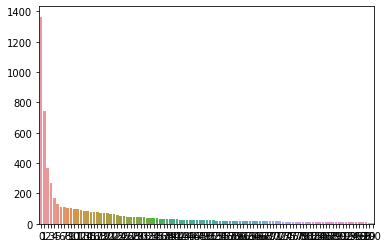

In [216]:
sns.barplot(np.arange(len(df_target_train["annotation_id"].value_counts().index)), df_target_train["annotation_id"].value_counts().values)

In [23]:
df_train["annotation_id"].value_counts().index

Index(['http://dbpedia.org/ontology/id', 'http://dbpedia.org/ontology/name',
       'http://dbpedia.org/ontology/description',
       'http://dbpedia.org/ontology/type', 'http://dbpedia.org/ontology/title',
       'http://dbpedia.org/ontology/state',
       'http://dbpedia.org/ontology/status',
       'http://dbpedia.org/ontology/date', 'http://dbpedia.org/ontology/code',
       'http://dbpedia.org/ontology/city',
       ...
       'http://dbpedia.org/ontology/event',
       'http://dbpedia.org/ontology/creator',
       'http://dbpedia.org/ontology/frequency',
       'http://dbpedia.org/ontology/releaseDate',
       'http://dbpedia.org/ontology/genus', 'http://dbpedia.org/ontology/tag',
       'http://dbpedia.org/ontology/owner',
       'http://dbpedia.org/ontology/party',
       'http://dbpedia.org/ontology/period',
       'http://dbpedia.org/ontology/result'],
      dtype='object', length=101)

In [31]:
df_train

,table_id,target_column,annotation_id
0,GitTables_41549,4,http://dbpedia.org/ontology/rank
1,GitTables_120703,1,http://dbpedia.org/ontology/gender
2,GitTables_64793,2,http://dbpedia.org/ontology/description
3,GitTables_73560,1,http://dbpedia.org/ontology/name
4,GitTables_116365,0,http://dbpedia.org/ontology/type
...,...,...,...
6222,GitTables_125732,9,http://dbpedia.org/ontology/name
6223,GitTables_39435,6,http://dbpedia.org/ontology/duration
6224,GitTables_2204,13,http://dbpedia.org/ontology/date
6225,GitTables_76276,7,http://dbpedia.org/ontology/start


In [96]:
types_2021 = np.array([t.split("/")[-1] for t in df_gt_2021['annotation_id'].value_counts().index.values])

In [100]:
print(len(types_2021), len(set(types)))
len(set(types_2021).intersection(set(types)))

122 101


73

In [141]:
types

array(['id', 'name', 'description', 'type', 'title', 'state', 'status',
       'date', 'code', 'city', 'value', 'source', 'year', 'time',
       'country', 'county', 'comment', 'notes', 'category', 'address',
       'age', 'gender', 'location', 'version', 'price', 'sex',
       'startDate', 'weight', 'class', 'endDate', 'field', 'region',
       'note', 'race', 'duration', 'species', 'score', 'position',
       'start', 'language', 'rank', 'height', 'population', 'order',
       'length', 'filename', 'model', 'role', 'series', 'max', 'min',
       'family', 'currency', 'definition', 'format', 'author', 'area',
       'domain', 'rating', 'parent', 'number', 'birthDate', 'alias',
       'postalCode', 'reference', 'cost', 'publisher', 'treatment',
       'created', 'company', 'district', 'elevation', 'project', 'day',
       'end', 'scientificName', 'abbreviation', 'part', 'countryCode',
       'season', 'topic', 'depth', 'road', 'prefix', 'month', 'route',
       'width', 'department', '

In [16]:
types = np.array([t.split("/")[-1] for t in df_target_train["annotation_id"].value_counts().index.values])
type2id = {t: i for i, t in enumerate(types)}
id2type = {i: t for i, t in enumerate(types)}
column_categories = {
    "Numerical": ['age', 'value', 'price', 'weight', 'score', 'rank', 'height', 'population', 'order', 'length', 'max', 'min', 'number', 'cost', 'elevation', 'depth', 'width', 'percentage'],
    "Categorical": ['id', 'name', 'description', 'type', 'title', 'state', 'status', 'code', 'city', 'source', 'country', 'county', 'comment', 'notes', 'category', 'address', 'gender', 'location', 'version', 'sex', 'class', 'field', 'region', 'note', 'race', 'species', 'position', 'language', 'filename', 'model', 'role', 'series', 'family', 'currency', 'definition', 'format', 'author', 'area', 'domain', 'rating', 'parent', 'alias', 'postalCode', 'reference', 'publisher', 'treatment', 'company', 'district', 'project', 'scientificName', 'abbreviation', 'part', 'countryCode', 'topic', 'road', 'prefix', 'route', 'department', 'zipCode', 'abstract', 'event', 'creator', 'genus', 'tag', 'owner', 'party', 'result'],
    "Datetime": ['date', 'time', 'startDate', 'endDate', 'birthDate', 'created', 'day', 'end', 'month', 'period', 'releaseDate', 'season'],
    "Other": ['start', 'duration', 'project', 'frequency']
}
is_numerical = np.array([t in column_categories["Numerical"] for t in types])
is_categorical = np.array([t in column_categories["Categorical"] for t in types])
is_datetime = np.array([t in column_categories["Datetime"] for t in types])
is_other = np.array([t in column_categories["Other"] for t in types])

In [67]:
testset = [(i, j) for i,j in df_target_test.values.tolist()]
trainset = [(i, j) for i,j,k in df_target_train.values.tolist()]

In [69]:
trainset[:10]

[('GitTables_41549', 4),
 ('GitTables_120703', 1),
 ('GitTables_64793', 2),
 ('GitTables_73560', 1),
 ('GitTables_116365', 0),
 ('GitTables_190325', 1),
 ('GitTables_55082', 0),
 ('GitTables_196360', 0),
 ('GitTables_2995', 7),
 ('GitTables_7634', 0)]

In [68]:
set(testset).intersection(trainset)

set()

In [52]:
testset = df_target_test.values

,table_id,target_column
0,GitTables_112510,4
1,GitTables_86067,1
2,GitTables_169746,8
3,GitTables_47830,6
4,GitTables_55159,1
...,...,...
6223,GitTables_56256,0
6224,GitTables_172560,9
6225,GitTables_162328,3
6226,GitTables_160082,1


In [51]:
types_test = np.array([t.split("/")[-1] for t in df_target_test["annotation_id"].value_counts().index.values])

KeyError: 'annotation_id'

In [30]:
df

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
0,1,AcronymID,Text,50.0,1,1,Code,Code,Acronym&nbsp;Code,Code&nbsp;d'acronyme,1,NaN,NaN,Text,1.0,1.0,NaN,NaN,NaN,2004-12-02 14:48:48
1,2,LanguageID,Text,NaN,0,0,Language,Langue,Language,Langue,1,NaN,NaN,Select,2.0,4.0,Languages,LanguageID,NaN,2004-11-26 10:14:07
2,3,DescriptionE,Text,255.0,1,1,E&nbsp;Description,Description&nbsp;F,English&nbsp;Description,Description&nbsp;anglaise,1,NaN,NaN,Text,3.0,2.0,NaN,NaN,NaN,2004-11-26 10:15:14
3,4,DescriptionF,Text,255.0,1,0,NaN,NaN,French&nbsp;Description,Description &nbsp;française,1,NaN,NaN,Text,4.0,3.0,NaN,NaN,NaN,2004-11-26 10:15:27
4,5,AcronymTypeID,Number,NaN,0,0,NaN,NaN,Type,Type,1,NaN,NaN,Select,5.0,5.0,AcronymTypes,Description,NaN,2004-11-26 10:15:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,71,AcronymID,Text,20.0,1,1,Acronym,Acronyme,Acronym,Acronyme,13,NaN,NaN,Select,2.0,2.0,Acronyms,AcronymID,NaN,2004-11-26 10:31:58
71,72,LastUpdate,Date,NaN,0,0,NaN,NaN,Last Update,Mis à jour,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-11-26 10:32:09
72,73,LastUpdate,Date,NaN,0,0,NaN,NaN,Last Update,Last Update,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-11-29 13:32:23
73,74,NoteE,Text,NaN,1,0,NaN,NaN,English&nbsp;Description,Description&nbsp;en&nbsp;anglais,3,NaN,NaN,Text,3.0,3.0,NaN,NaN,NaN,2004-12-23 09:31:41


In [28]:
df = pd.read_csv("/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/GitTables_26251.csv")

In [29]:
df

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
0,1,AcronymID,Text,50.0,1,1,Code,Code,Acronym&nbsp;Code,Code&nbsp;d'acronyme,1,NaN,NaN,Text,1.0,1.0,NaN,NaN,NaN,2004-12-02 14:48:48
1,2,LanguageID,Text,NaN,0,0,Language,Langue,Language,Langue,1,NaN,NaN,Select,2.0,4.0,Languages,LanguageID,NaN,2004-11-26 10:14:07
2,3,DescriptionE,Text,255.0,1,1,E&nbsp;Description,Description&nbsp;F,English&nbsp;Description,Description&nbsp;anglaise,1,NaN,NaN,Text,3.0,2.0,NaN,NaN,NaN,2004-11-26 10:15:14
3,4,DescriptionF,Text,255.0,1,0,NaN,NaN,French&nbsp;Description,Description &nbsp;française,1,NaN,NaN,Text,4.0,3.0,NaN,NaN,NaN,2004-11-26 10:15:27
4,5,AcronymTypeID,Number,NaN,0,0,NaN,NaN,Type,Type,1,NaN,NaN,Select,5.0,5.0,AcronymTypes,Description,NaN,2004-11-26 10:15:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,71,AcronymID,Text,20.0,1,1,Acronym,Acronyme,Acronym,Acronyme,13,NaN,NaN,Select,2.0,2.0,Acronyms,AcronymID,NaN,2004-11-26 10:31:58
71,72,LastUpdate,Date,NaN,0,0,NaN,NaN,Last Update,Mis à jour,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-11-26 10:32:09
72,73,LastUpdate,Date,NaN,0,0,NaN,NaN,Last Update,Last Update,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-11-29 13:32:23
73,74,NoteE,Text,NaN,1,0,NaN,NaN,English&nbsp;Description,Description&nbsp;en&nbsp;anglais,3,NaN,NaN,Text,3.0,3.0,NaN,NaN,NaN,2004-12-23 09:31:41


# Results analysis

In [4]:
import argparse
import json
import math
import os
import random
from time import time

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import torch
import seaborn as sns

In [167]:
target_type_id

26

In [168]:
class_count_test[26]

9.0

types = np.array(['id', 'name', 'description', 'type', 'title', 'state', 'status',
       'date', 'code', 'city', 'value', 'source', 'year', 'time',
       'country', 'county', 'comment', 'notes', 'category', 'address',
       'age', 'gender', 'location', 'version', 'price', 'sex',
       'startDate', 'weight', 'class', 'endDate', 'field', 'region',
       'note', 'race', 'duration', 'species', 'score', 'position',
       'start', 'language', 'rank', 'height', 'population', 'order',
       'length', 'filename', 'model', 'role', 'series', 'max', 'min',
       'family', 'currency', 'definition', 'format', 'author', 'area',
       'domain', 'rating', 'parent', 'number', 'birthDate', 'alias',
       'postalCode', 'reference', 'cost', 'publisher', 'treatment',
       'created', 'company', 'district', 'elevation', 'project', 'day',
       'end', 'scientificName', 'abbreviation', 'part', 'countryCode',
       'season', 'topic', 'depth', 'road', 'prefix', 'month', 'route',
       'width', 'department', 'percentage', 'zipCode', 'abstract',
       'event', 'creator', 'frequency', 'releaseDate', 'genus', 'tag',
       'owner', 'party', 'period', 'result'])
type2id = {t: i for i, t in enumerate(types)}
id2type = {i: t for i, t in enumerate(types)}
column_categories = {
    "Numerical": ['age', 'value', 'price', 'weight', 'score', 'rank', 'height', 'population', 'order', 'length', 'max', 'min', 'number', 'cost', 'elevation', 'depth', 'width', 'percentage'],
    "Categorical": ['id', 'name', 'description', 'type', 'title', 'state', 'status', 'code', 'city', 'source', 'country', 'county', 'comment', 'notes', 'category', 'address', 'gender', 'location', 'version', 'sex', 'class', 'field', 'region', 'note', 'race', 'species', 'position', 'language', 'filename', 'model', 'role', 'series', 'family', 'currency', 'definition', 'format', 'author', 'area', 'domain', 'rating', 'parent', 'alias', 'postalCode', 'reference', 'publisher', 'treatment', 'company', 'district', 'project', 'scientificName', 'abbreviation', 'part', 'countryCode', 'topic', 'road', 'prefix', 'route', 'department', 'zipCode', 'abstract', 'event', 'creator', 'genus', 'tag', 'owner', 'party', 'result'],
    "Datetime": ['date', 'time', 'startDate', 'endDate', 'birthDate', 'created', 'day', 'end', 'month', 'period', 'releaseDate', 'season'],
    "Other": ['start', 'duration', 'project', 'frequency']
}
is_numerical = np.array([t in column_categories["Numerical"] for t in types])
is_categorical = np.array([t in column_categories["Categorical"] for t in types])
is_datetime = np.array([t in column_categories["Datetime"] for t in types])
is_other = np.array([t in column_categories["Other"] for t in types])

In [8]:

base_dirpath = "/data/zhihao/TU/GitTables/semtab_gittables/2022/"
seperator = "semi1"
basename = seperator+"_cv_{}.csv"
df_list = []
cv = 0
filepath = os.path.join(base_dirpath, basename.format(cv))
df_test = pd.read_csv(filepath)

df_group_test = df_test.groupby("table_id")



df_list = []
for i in range(5):
    if i == cv:
        continue
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_train = pd.concat(df_list, axis=0)
df_group_train = df_train.groupby("table_id")

In [33]:
# analyze col correlation
corr_matrix = np.zeros((len(types), len(types)))
for i, (index, group_df) in enumerate(df_group_train):
    if len(group_df) == 0:
        continue
    class_ids = group_df[group_df["class_id"] > -1]["class_id"].values
    for i in range(len(class_ids)):
        for j in range(i+1, len(class_ids)):
            corr_matrix[class_ids[i], class_ids[j]] += 1
            corr_matrix[class_ids[j], class_ids[i]] += 1

In [34]:
corr_matrix

array([[  0., 151.,  41., ...,   0.,   1.,   0.],
       [151.,   0.,  43., ...,   1.,   0.,   0.],
       [ 41.,  43.,   0., ...,   1.,   2.,   0.],
       ...,
       [  0.,   1.,   1., ...,   0.,   0.,   0.],
       [  1.,   0.,   2., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [32]:
class_ids

array([0])

In [24]:
labeled_cols = group_df[]

,table_id,col_idx,class,class_id,data
0,GitTables_100210,0,id,0,163915846063865;155711202630775;20533463706221...
1,GitTables_100210,1,NaN,-1,False;False;False;False;False;False;False;Fals...
2,GitTables_100210,2,NaN,-1,2021-03-22 14:20:57;2021-03-22 14:20:57;2021-0...
3,GitTables_100210,4,NaN,-1,2016-08-04 17:26:14;2016-07-14 23:52:42;2016-1...
4,GitTables_100210,6,NaN,-1,54ce99fa85c92b1d87678436e956a2e8;5b6cf869265c1...
5,GitTables_100210,8,NaN,-1,2104505001950;2104505001950;2104505001950;2104...


In [93]:
filepath

'/data/zhihao/TU/GitTables/semtab_gittables/2022/semi1_cv_4.csv'

In [62]:
null_tables = []
for i, group_df in df_group_train:
    if len(group_df[group_df['class_id'] > -1]) == 0:
        null_tables.append(i)

In [63]:
null_tables

[]

In [30]:
g

,table_id,col_idx,class,class_id,data
0,GitTables_100210,0,id,0,163915846063865;155711202630775;20533463706221...
1,GitTables_100210,1,NaN,-1,False;False;False;False;False;False;False;Fals...
2,GitTables_100210,2,NaN,-1,2021-03-22 14:20:57;2021-03-22 14:20:57;2021-0...
3,GitTables_100210,4,NaN,-1,2016-08-04 17:26:14;2016-07-14 23:52:42;2016-1...
4,GitTables_100210,6,NaN,-1,54ce99fa85c92b1d87678436e956a2e8;5b6cf869265c1...
5,GitTables_100210,8,NaN,-1,2104505001950;2104505001950;2104505001950;2104...


In [9]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
# with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
#     results = json.load(f)
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-{seperator}-poolv0-unlabeled0-randTrue-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)

labels_train = np.array(results['train']['tr_true_list'])
preds_train = np.array(results['train']['tr_pred_list'])
class_f1_train = np.array(results['train']['tr_class_f1'])

labels = np.array(results['f1_micro']['true_list'])
preds = np.array(results['f1_micro']['pred_list'])
class_f1 = np.array(results['f1_micro']['ts_class_f1'])
assert len(labels) == len(df_test["class_id"][df_test["class_id"]>-1])


In [95]:
f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-{seperator}-poolv0-unlabeled0-randTrue-bs16-ml64-ne50-do0.1_eval.json"

'/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-poolv0-unlabeled0-randTrue-bs16-ml64-ne50-do0.1_eval.json'

In [69]:
results.keys()

dict_keys(['train', 'f1_macro', 'f1_micro', 'loss'])

In [71]:
results['train'].keys()

dict_keys(['tr_class_f1', 'tr_macro_f1', 'tr_micro_f1', 'tr_loss', 'tr_pred_list', 'tr_true_list', 'tr_logits_list'])

<Axes: >

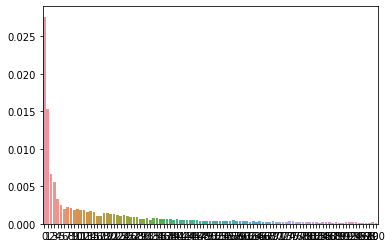

In [11]:
import seaborn as sns
class_count = df_train["class_id"][df_train["class_id"]>-1].value_counts().sort_index().values
class_freq = class_count/len(df_train)
sns.barplot(x=np.arange(len(class_freq)), y=class_freq)

<Axes: >

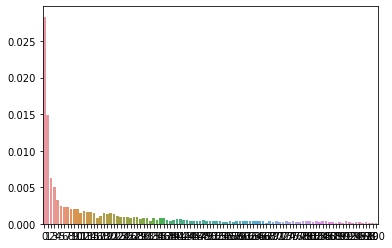

In [12]:
import seaborn as sns
class_count_test = np.zeros(len(class_count))
class_count_test[df_test["class_id"][df_test["class_id"]>-1].value_counts().sort_index().keys()] = df_test["class_id"][df_test["class_id"]>-1].value_counts().sort_index().values
class_freq_test = class_count_test/len(df_test)
sns.barplot(x=np.arange(len(class_freq_test)), y=class_freq_test)

In [20]:
num = 0
column_length_test = []
column_length_train = []
for i, (index, group_df) in enumerate(df_group_test):
    column_length_test.append(len(group_df[group_df["class_id"]>-1]))
for i, (index, group_df) in enumerate(df_group_train):
    column_length_train.append(len(group_df[group_df["class_id"]>-1]))

<Axes: ylabel='Count'>

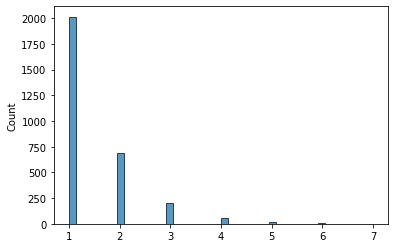

In [21]:
sns.histplot(column_length_train)

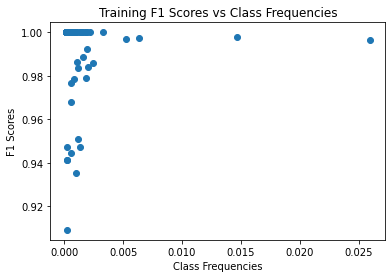

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming class_f1 and class_frequencies are your actual data
plt.scatter(class_freq, class_f1_train)
plt.xlabel('Class Frequencies')
plt.ylabel('F1 Scores')
plt.title('Training F1 Scores vs Class Frequencies')
plt.show()

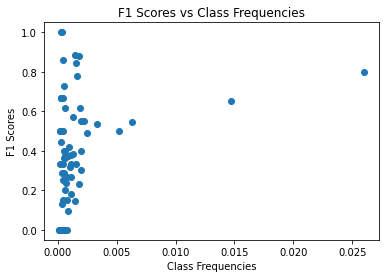

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming class_f1 and class_frequencies are your actual data
plt.scatter(class_freq, class_f1)
plt.xlabel('Class Frequencies')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Class Frequencies')
plt.show()

In [19]:
# analyze the largest class
largest_class = np.argmax(class_freq)
mask = labels == largest_class
labels_target = labels[mask]
preds_target = preds[mask]

In [20]:
len(labels_target)

258

In [56]:
# TODO
count = 0
column_length_test_all = []
for i, (index, group_df) in enumerate(df_group_test):
    column_length_test_all += [len(group_df[group_df["class_id"]>-1])] * len(group_df)
column_length_test_all = np.array(column_length_test_all)
print(np.unique(column_length_test_all))

[0 1 2 3 4 5 6]


In [19]:
num = 0
target_type = "id"
column_length_test = []
column_length_train = []
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        column_length_test.append(len(group_df[group_df["class_id"]>-1]))
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        column_length_train.append(len(group_df[group_df["class_id"]>-1]))
        

<Axes: ylabel='Count'>

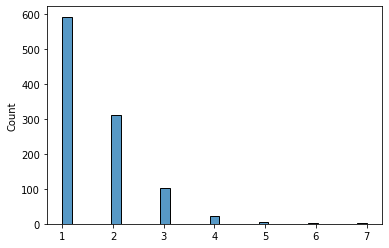

In [108]:
sns.histplot(column_length_train)

<Axes: ylabel='Count'>

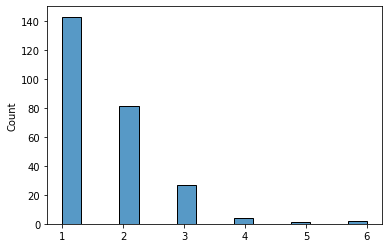

In [27]:
sns.histplot(column_length_test)

In [28]:
for i in np.unique(column_length_test):
    mask = column_length_test==i
    acc = (labels_target[mask] == preds_target[mask]).sum()/mask.sum()
    # cl_freq = class_freq[labels[mask]].mean()
    print(i, acc)

1 0.7972027972027972
2 0.7654320987654321
3 0.9629629629629629
4 0.75
5 0.0
6 0.5


/tmp/ipykernel_2883630/1801666482.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = labels == target_type_id


0


<Axes: ylabel='Count'>

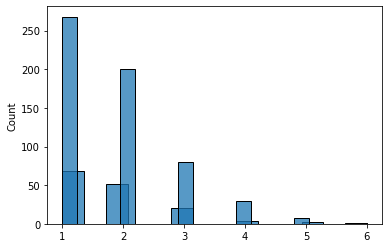

In [110]:
num = 0
target_type = 'name'
column_length_test = []
column_length_train = []
target_type_id = np.where(types==target_type )[0][0]
mask = labels == target_type_id
labels_target = labels[mask]
preds_target = preds[mask]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        column_length_test.append(len(group_df[group_df["class_id"]>-1]))
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        column_length_train.append(len(group_df[group_df["class_id"]>-1]))
print(len(labels_target))
sns.histplot(column_length_test)
sns.histplot(column_length_train)

In [32]:
for i in np.unique(column_length_test):
    mask = column_length_test==i
    acc = (labels_target[mask] == preds_target[mask]).sum()/mask.sum()
    # cl_freq = class_freq[labels[mask]].mean()
    print(i, acc)

1 0.5
2 0.6274509803921569
3 0.75
4 1.0
5 1.0
6 1.0


66


<Axes: ylabel='Count'>

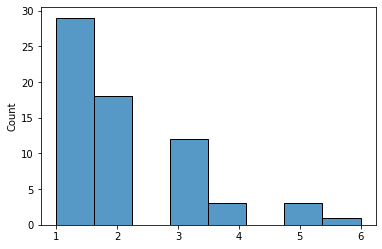

In [36]:
num = 0
target_type = 'description' # 'description', 'type'
column_length_test = []
target_type_id = np.where(types==target_type )[0][0]
mask = labels == target_type_id
labels_target = labels[mask]
preds_target = preds[mask]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        column_length_test.append(len(group_df[group_df["class_id"]>-1]))
print(len(labels_target))
sns.histplot(column_length_test)

In [37]:
for i in np.unique(column_length_test):
    mask = column_length_test==i
    acc = (labels_target[mask] == preds_target[mask]).sum()/mask.sum()
    # cl_freq = class_freq[labels[mask]].mean()
    print(i, acc)

1 0.5517241379310345
2 0.7222222222222222
3 0.75
4 0.3333333333333333
5 0.3333333333333333
6 0.0


51


<Axes: ylabel='Count'>

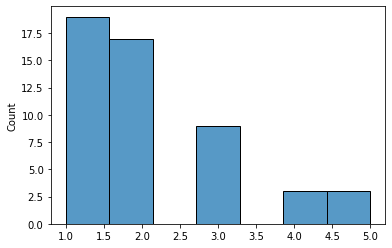

In [34]:
num = 0
target_type = 'type' # 'description', 'type'
column_length_test = []
target_type_id = np.where(types==target_type )[0][0]
mask = labels == target_type_id
labels_target = labels[mask]
preds_target = preds[mask]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        column_length_test.append(len(group_df[group_df["class_id"]>-1]))
print(len(labels_target))
sns.histplot(column_length_test)

In [35]:
for i in np.unique(column_length_test):
    mask = column_length_test==i
    acc = (labels_target[mask] == preds_target[mask]).sum()/mask.sum()
    # cl_freq = class_freq[labels[mask]].mean()
    print(i, acc)

1 0.3684210526315789
2 0.7647058823529411
3 0.7777777777777778
4 0.3333333333333333
5 0.0


In [106]:
target_type = "gender"
target_type_id = np.where(types==target_type )[0][0]
pd.Series((types[preds_train[labels_train==target_type_id]])).value_counts()

gender    36
sex        4
dtype: int64

In [102]:
# Training
acc_order = np.argsort(class_f1_train)
for i in range(10):
    num_train_false = sum(labels_train[labels_train == acc_order[i]] != preds_train[labels_train == acc_order[i]])
    print(types[acc_order[i]], class_f1[acc_order[i]].round(2), class_f1_train[acc_order[i]].round(2), class_count[acc_order[i]], class_count_test[acc_order[i]], "|", num_train_false)

frequency 0.0 0.91 7 1.0 | 1
sex 0.4 0.94 36 8.0 | 0
project 0.0 0.94 11 2.0 | 1
depth 0.0 0.94 9 2.0 | 1
rank 0.4 0.94 23 6.0 | 2
countryCode 0.4 0.95 9 3.0 | 0
gender 0.55 0.95 49 12.0 | 4
version 0.33 0.95 38 9.0 | 1
score 0.1 0.97 23 7.0 | 1
position 0.29 0.98 24 5.0 | 1


In [81]:
# 0
acc_order = np.argsort(class_f1)
for i in range(10):
    print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]].round(2), class_f1_train[acc_order[-i-1]].round(2), class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])

birthDate 1.0 1.0 15 4.0
address 0.96 1.0 58 15.0
county 0.92 1.0 60 14.0
family 0.86 1.0 17 4.0
currency 0.86 1.0 17 4.0
id 0.82 1.0 1036 264.0
year 0.81 0.98 73 19.0
part 0.67 1.0 10 2.0
releaseDate 0.67 1.0 8 2.0
percentage 0.67 1.0 10 1.0


In [39]:
512/12

42.666666666666664

In [17]:
freq_order = np.argsort(class_freq)
for i in range(5):
    print(types[freq_order[-i-1]], class_f1[freq_order[-i-1]], class_count[freq_order[-i-1]], class_count_test[freq_order[-i-1]])
    target_type_id = freq_order[-i-1]
    # print(pd.Series((types[preds[labels==target_type_id]])).value_counts())
    print("===================================================")
    

id 0.8183556405353729 997 260.0
name 0.6137184115523464 552 137.0
description 0.4724409448818897 240 58.0
type 0.5106382978723404 201 46.0
title 0.4482758620689655 119 30.0


name 151.0
type 50.0
description 41.0
code 25.0
title 17.0


In [38]:

freq_order = np.argsort(class_freq)
for i in range(5):
    print(types[freq_order[-i-1]], class_f1[freq_order[-i-1]], class_count[freq_order[-i-1]], class_count_test[freq_order[-i-1]])
    target_type_id = freq_order[-i-1]
    corr_order = np.argsort(corr_matrix[target_type_id])
    for j in range(5):
        print(types[corr_order[-j-1]], corr_matrix[target_type_id, corr_order[-j-1]])
    print("===================================================")

id 0.8183556405353729 997 260.0
name 151.0
type 50.0
description 41.0
code 25.0
title 17.0
name 0.6137184115523464 552 137.0
id 151.0
description 43.0
type 34.0
code 20.0
status 13.0
description 0.4724409448818897 240 58.0
name 43.0
id 41.0
type 26.0
title 14.0
status 9.0
type 0.5106382978723404 201 46.0
id 50.0
name 34.0
description 26.0
value 7.0
title 6.0
title 0.4482758620689655 119 30.0
id 17.0
description 14.0
name 8.0
type 6.0
date 5.0


In [18]:
freq_order = np.argsort(class_freq)
for i in range(5):
    print(types[freq_order[-i-1]], class_f1[freq_order[-i-1]], class_count[freq_order[-i-1]], class_count_test[freq_order[-i-1]])
    target_type_id = freq_order[-i-1]
    print(pd.Series((types[preds[labels==target_type_id]])).value_counts())
    print("===================================================")

id 0.8183556405353729 997 260.0
id             214
code             6
name             5
country          3
category         3
state            3
number           2
model            2
source           2
description      2
event            1
date             1
duration         1
startDate        1
series           1
value            1
age              1
filename         1
role             1
type             1
population       1
time             1
region           1
elevation        1
rank             1
field            1
road             1
comment          1
dtype: int64
name 0.6137184115523464 552 137.0
name           85
description    12
id             10
title           7
type            4
state           3
class           2
parent          1
domain          1
city            1
code            1
model           1
field           1
language        1
location        1
treatment       1
status          1
category        1
area            1
address         1
race            1
dtype: int6

In [225]:
np.nonzero(group_df["class_id"].values==target_type_id)[0]

array([], dtype=int64)

In [222]:
np.nonzero(group_df["class_id"].values==target_type_id)[0][0]

4

In [111]:
# num = 0
# wrong_num = 0
# target_type = "gender"
# target_type_id = np.where(types==target_type )[0][0]
# print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
# print("================================")
# for i, (index, group_df) in enumerate(df_group_train):
#     if target_type in group_df["class"].values:
#         # if types[preds_train[labels_train==target_type_id]][num] != target_type:
#         #     print(types[preds_train[labels_train==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
#         #     wrong_num += 1
#         #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
#         #     print("================================")
#         #     if wrong_num > 30:
#         #         break
        
        
#         print(types[preds_train[labels_train==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
#         print(group_df[group_df["class_id"]==-1][["class", "data"]])
#         print("================================")
#         num += 1
#         # if num > 20:
#         #     break

In [109]:
num = 0
wrong_num = 0
target_type = "gender"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        if types[preds_train[labels_train==target_type_id]][num] != target_type:
            print(types[preds_train[labels_train==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if wrong_num > 30:
                break
        
        
        # print(types[preds_train[labels_train==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break

0.5517241379310345 49 12.0 8
sex ||      class                                               data
51  gender  Male;Female;Male;Female;Male;Female;Male;Femal...
53    year  2019;2019;2018;2018;2017;2017;2016;2016;2015;2...
   class                                               data
50   NaN                            1;2;1;2;1;2;1;2;1;2;1;2
52   NaN  2019;2019;2018;2018;2017;2017;2016;2016;2015;2...
54   NaN  True;True;True;True;True;True;True;True;True;T...
55   NaN  True;True;True;True;True;True;True;True;True;T...
56   NaN  4567062;5158370;4592218;5085778;4630916;501927...
57   NaN  51672.1106;54804.93392;51797.83161;54417.45082...
58   NaN  36636;42837;36765;43137;36798;42403;36161;4146...
59   NaN  Restaurants & Food Services;Restaurants & Food...
60   NaN  722Z;722Z;722Z;722Z;722Z;722Z;722Z;722Z;722Z;7...
61   NaN  restaurants-food-services;restaurants-food-ser...
62   NaN  0.469599911;0.530400089;0.474500919;0.52549908...
sex ||        class                                       

IndexError: index 40 is out of bounds for axis 0 with size 40

In [91]:
(labels_train==target_type_id).sum()

6

In [90]:
num

6

In [126]:
types[preds[labels==target_type_id]]

array(['title', 'title', 'role', 'title', 'title', 'title', 'name',
       'name', 'name', 'name', 'description', 'name', 'name', 'name',
       'title', 'description', 'title', 'title', 'title', 'description',
       'title', 'title', 'title', 'title', 'name', 'prefix', 'notes',
       'description', 'title', 'name'], dtype='<U14')

In [ ]:
Laravel Admin Starter

In [54]:
# target_1 = group_df["data"].values


In [60]:
# target_2 = group_df["data"].values

In [74]:
target_2_text

'1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50 98537;59976;30448;34772;84012;86980;27787;87686;84144;18487;24470;67192;49572;25579;62465;64030;46621;80101;35884;57051;85644;31302;62716;56183;70753;53898;76262;98138;63525;54783;27602;81050;40444;31949;26092;97810;93760;76762;31475;23600;19568;88906;33764;61890;84485;49810;15617;42402;76499;83976 Norma Fisher;Jorge Sullivan;Elizabeth Woods;Susan Wagner;Peter Montgomery;Theodore Mcgrath;Stephanie Collins;Stephanie Sutton;Brian Hamilton;Susan Levy;Sean Green;Kimberly Smith;Jennifer Summers;April Snyder;Dana Nguyen;Cheryl Bradley;Walter Pratt;Bobby Flores;Tasha Rodriguez;Michelle Kelley;Kimberly Maynard;Laurie Wallace;Janice Johnston;Collin Lopez;Mary Alvarez;Peter Mcdowell;Sarah Villanueva;Kimberly Myers;Desiree Cain;Stephanie Lawrence;Lauren Hayes;Whitney Stark;Angela Salazar;Mr. Ryan Sanchez;Autumn Robinson;Faith Cabrera;Charles Wolfe;Kenneth K

In [63]:
target_1_text = " ".join(target_1)
target_2_text = " ".join(target_2)

In [71]:
import fasttext as ft
ft_model = ft.load_model('/data/zhihao/TU/crawl-300d-2M-subword.bin')

In [72]:
target_1_embs = ft_model.get_sentence_vector(target_1_text)
target_2_embs = ft_model.get_sentence_vector(target_2_text)

In [73]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity([target_1_embs], [target_2_embs])
print(f"Cosine Similarity: {similarity[0][0]}")

Cosine Similarity: 0.884312629699707


In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([target_1_text, target_2_text])
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
print(f"Cosine Similarity: {cosine_sim[0][0]}")

Cosine Similarity: 0.21232066763325166


In [80]:
num = 0
wrong_num = 0
target_type = "title"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        text_i = " ".join(group_df["data"].values)
        text_i_embs = ft_model.get_sentence_vector(text_i.replace("\n", " "))
        similarity_i = cosine_similarity([target_2_embs], [text_i_embs])
        if similarity_i > 0.8:
            print(types[preds[labels==target_type_id]][num], similarity_i, "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
        # if "Laravel Admin Starter" in " ".join(group_df["data"].values):
        # print(types[preds[labels==target_type_id]][num], similarity_i, "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
            # break
        num += 1
        # if num > 20:
        #     break

0.4482758620689655 119 30.0 13
role [[0.83062446]] ||       class                                               data
1424  title  Magistrate;Circuit Judge;Magistrate;Magistrate...
     class                                               data
1422   NaN                                      1;2;3;4;5;6;7
1423   NaN                 Emp1;Emp1;Emp3;Emp4;Emp5;Emp6;Emp7
1425   NaN                        Joe;Joe;Joe;Joe;Joe;Joe;Joe
1426   NaN  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
1427   NaN  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
1428   NaN  Baroness;His Honour Judge;Baroness;Baroness;Ba...
1429   NaN                                      1;5;1;1;1;1;1
1430   NaN  No Work Pattern (M to F);Salaried Judiciary 5 ...
1431   NaN  thomas15@stewart-bowman.com;qgrimes@gmail.com;...
1432   NaN  2008-07-18 00:00:00;2006-08-10 00:00:00;2008-0...
1433   NaN  1900-01-01 00:00:00;1900-01-01 00:00:00;1900-0...
1434   NaN                 True;True;True;True;True;True;True
1435   NaN  20

In [76]:
num = 0
wrong_num = 0
target_type = "name"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        if "Fisher" in " ".join(group_df["data"].values) and "2017-07-28" in " ".join(group_df["data"].values):
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            break
        num += 1
        # if num > 20:
        #     break

0.6137184115523464 552 137.0 85
name ||      class                                               data
8780  name  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
     class                                               data
8778   NaN  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
8779   NaN  98537;59976;30448;34772;84012;86980;27787;8768...
8781   NaN  2017-07-28 07:53:12;2007-04-10 02:49:10;2017-0...
8782   NaN  18768003135;15381506760;19948246503;1820017874...
8783   NaN  643542;999540;231179;868780;163623;389293;8571...
8784   NaN  14;68;70;46;43;67;50;70;19;14;6;13;29;7;72;46;...
8785   NaN  8109;89132;21237;21728;45368;69900;33359;15864...
8786   NaN  1;2;3;4;1;2;3;4;1;2;3;4;5;2;3;4;5;6;1;2;3;4;5;...
8787   NaN  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
8788   NaN  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...
8789   NaN  2017-07-28 07:53:12;2007-04-10 02:49:10;2017-0...
8790   NaN  2017-07-28 07:53:12;2007-04-10 02:49:10;2017-0...


In [67]:
num = 0
wrong_num = 0
target_type = "project"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        
        print(group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break

0.0 11 2.0 0
       class                                               data
938  project  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
    class                                               data
939   NaN  https://api.github.com/repos/jjgomera/pychemqt...
940   NaN  11161411;26427893;27472783;27489574;27496810;2...
941   NaN  1355;1628;1482;770;10221;652;2640;4900;931;272...
942   NaN  3;6;19;12;1;1;12;7;3;2;9;1;5;11;7;81;1;7;1;32;...
943   NaN  0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...
944   NaN  0;6;49;27;39;0;35;15;1;15;4;0;8;0;17;50;71;0;0...
945   NaN  2;15;21;21;11;1;13;20;6;85;2;2;20;2;34;17;4;9;...
946   NaN  19;212;9;105;54;1;16;17;13;72;1;3;18;1;48;11;1...
947   NaN  62;5100;1;129;258;0;88;144;1;571;6;1;0;1;500;5...
948   NaN  23;455;4;37;69;0;50;72;2;285;3;1;0;1;178;22;44...
949   NaN  Python;Python;Python;Python;Python;Python;Pyth...
950   NaN  2014-05-14 15:11:59;2015-09-22 15:41:48;2014-1...
951   NaN  6;5;6;5;5;5;5;5;5;6;5;5;5;5;5;4;4;4;4;4;4;4;4;...
     

In [41]:
num = 0
wrong_num = 0
target_type = "title"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break

0.4482758620689655 119 30.0 13
title ||      class                                               data
953  title  Non-competes, Business Dynamism, and Concentra...
    class                                               data
949   NaN  dataset-136;dataset-136;dataset-136;dataset-13...
950   NaN  10.2139/ssrn.3172477;10.7591/9781501717734-009...
951   NaN  SSRN Electronic Journal;{'id': 'jour.1027390',...
952   NaN  Florida WAGES;Florida WAGES;Florida WAGES;Flor...
source ||        class                                               data
1069      id  532255;6570774;3979020;548749;534719;549166;55...
1070   title  Caw;Caw!: magazine of Students for a Democrati...
1082  format  print;electronic|||electronic resource|||remot...
     class                                               data
1071   NaN  Free you (Menlo Park, Calif.)|||Human Institut...
1072   NaN  SDS fire;SDS fire;SDS new left notes;SDS new l...
1073   NaN  New York;New York, N.Y;Menlo Park, CA;Minneapo...
1074   NaN  Stude

In [129]:
num = 0
wrong_num = 0
target_type = "name"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break

0.6488294314381272 552 137.0 97
name ||   class                                               data
0    id  state_id_0;state_id_1;state_id_2;state_id_3;st...
1  name  Alytaus apskritis;Kauno apskritis;Klaipėdos ap...
  class                                               data
2   NaN                                A;K;L;M;P;S;J;T;U;V
3   NaN  base.lt;base.lt;base.lt;base.lt;base.lt;base.l...
name ||    class                                               data
22  name  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
   class                                               data
23   NaN  230 Megan Junctions Suite 197\nNorth Thomas, O...
24   NaN  2700 S;1700 W;Room 100;Room 202;Room ;5325 S;2...
25   NaN  03:00 PM-07:00 PM;10:00 AM-02:00 PM;10:00 AM-0...
26   NaN  ho86815543;ho77224042;ho82147400;ho37957929;ho...
27   NaN  False;False;False;False;False;False;False;Fals...
28   NaN  True;True;True;True;True;True;True;True;True;T...
29   NaN  poll61582448;poll49054574;poll89601719;poll258..

In [135]:
num = 0
wrong_num = 0
target_type = "type"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if types[preds[labels==target_type_id]][num] == "catogery":
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if wrong_num > 30:
                break
        
        
        # print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break


0.5652173913043478 201 46.0 26


In [230]:
# num = 0
# target_type = "id"
# target_type_id = np.where(types==target_type )[0][0]
# for i, (index, group_df) in enumerate(df_group_test):
#     if target_type in group_df["class"].values:
#         if preds[labels==target_type_id][num] != target_type_id:
#             print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
#             print("================================")
#         num += 1
#         if num > 60:
#             break

In [231]:
num = 0
target_type = "id"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

id ||   class                                               data
0    id  state_id_0;state_id_1;state_id_2;state_id_3;st...
1  name  Alytaus apskritis;Kauno apskritis;Klaipėdos ap...
id ||    class                                               data
43    id  1;2;3;4;5;6;857;858;859;860;861;862;1713;1714;...
46  date  2015-09-17;2015-09-17;2015-09-17;2015-09-17;20...
id ||    class                                               data
51    id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
rank ||       class                                               data
88  species  setosa;setosa;setosa;setosa;setosa;setosa;seto...
89       id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
id ||       class         data
147      id  1;2;3;4;5;6
162  status  1;1;1;1;1;1
id ||     class                                       data
219    id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17
id ||     class                                               data
244    id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;1

In [206]:
num = 0
target_type = "name"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    target_id = np.nonzero(group_df["class_id"].values==target_type_id)[0]
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

name ||   class                                               data
0    id  state_id_0;state_id_1;state_id_2;state_id_3;st...
1  name  Alytaus apskritis;Kauno apskritis;Klaipėdos ap...
name ||    class                                               data
22  name  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
name ||     class                                               data
190  name  Service 1;Cubierta 1;Cubierta 2;Cubierta 3;Cub...
name ||      class                                               data
275     id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
278   name  一般土建工程;电气工程;采暖工程;给排水工程;通风工程;消防预埋工程;一般土建工程;电气工程...
281  state                                                0.0
name ||         class                                               data
309      name  Mozzarella;Cheddar;Pepper Jack;Feta;Butter;Sou...
310  category  Dairy;Dairy;Dairy;Dairy;Dairy;Dairy;Dairy;Dair...
name ||     class                                               data
359    id  1;2;3;4;5;6;7;8;9;

In [186]:
# 3 birthDate, year, 
acc_order = np.argsort(class_f1)
for i in range(10):
    print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]], class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])

percentage 1.0 10 1.0
birthDate 1.0 15 4.0
address 0.8823529411764706 58 15.0
year 0.8780487804878049 73 19.0
currency 0.8571428571428571 17 4.0
county 0.8461538461538461 60 14.0
id 0.7992424242424242 1036 264.0
country 0.7777777777777778 64 17.0
filename 0.7272727272727273 20 4.0
abbreviation 0.6666666666666666 11 2.0


In [234]:
acc_order = np.argsort(class_f1)
for i in range(11, 20):
    print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]], class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])

scientificName 0.6666666666666666 12 3.0
family 0.6666666666666666 17 4.0
name 0.653968253968254 586 146.0
city 0.6190476190476191 75 20.0
species 0.6153846153846153 25 7.0
age 0.5714285714285715 52 15.0
status 0.5500000000000002 79 21.0
date 0.5490196078431373 87 22.0
description 0.5454545454545454 252 63.0


In [121]:

for i in range(41, 50):
    if  class_count_test[acc_order[-i-1]] > 5:
        print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]], class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])
        target_type_id = acc_order[-i-1]
        print(pd.Series((types[preds[labels==target_type_id]])).value_counts())
        acc_order = np.argsort(class_f1)
        print("===================================================")

version 0.3333333333333333 38 9.0
version    3
status     1
score      1
cost       1
order      1
sex        1
source     1
dtype: int64
notes 0.33333333333333326 39 10.0
description    3
notes          3
comment        2
value          1
type           1
dtype: int64
price 0.3 41 9.0
price     3
number    1
weight    1
min       1
end       1
score     1
id        1
dtype: int64
class 0.3 32 9.0
class          3
id             1
duration       1
description    1
project        1
species        1
field          1
dtype: int64
field 0.2857142857142857 23 7.0
id            2
field         2
model         1
definition    1
name          1
dtype: int64


In [117]:
target_type = "sex"
target_type_id = np.where(types==target_type )[0][0]
pd.Series((types[preds[labels==target_type_id]])).value_counts()

gender    4
sex       3
name      1
dtype: int64

In [266]:
acc_order = np.argsort(class_f1)
for i in range(21, 30):
    print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]], class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])
    

event 0.5 8 3.0
treatment 0.5 11 1.0
releaseDate 0.5 8 2.0
type 0.5 208 53.0
format 0.5 13 3.0
domain 0.5 16 2.0
state 0.4918032786885245 99 26.0
road 0.4444444444444444 10 3.0
sex 0.4210526315789474 39 8.0


In [188]:
acc_order = np.argsort(class_f1)
num_zero = sum(class_f1==0)
print(num_zero)
for i in range(num_zero):
    print(types[acc_order[i]], class_f1[acc_order[i]], class_count[acc_order[i]], class_count_test[acc_order[i]])

41
min 0.0 14 4.0
elevation 0.0 13 2.0
district 0.0 10 3.0
company 0.0 13 2.0
created 0.0 11 4.0
publisher 0.0 12 3.0
cost 0.0 14 3.0
reference 0.0 10 3.0
alias 0.0 12 3.0
number 0.0 15 4.0
parent 0.0 12 4.0
area 0.0 15 4.0
author 0.0 14 4.0
definition 0.0 14 4.0
period 0.0 7 1.0
role 0.0 16 4.0
project 0.0 11 2.0
length 0.0 19 5.0
day 0.0 12 3.0
countryCode 0.0 10 3.0
party 0.0 7 1.0
owner 0.0 6 2.0
tag 0.0 5 1.0
genus 0.0 6 2.0
frequency 0.0 8 2.0
creator 0.0 8 2.0
abstract 0.0 7 1.0
zipCode 0.0 9 2.0
department 0.0 7 2.0
width 0.0 9 2.0
month 0.0 10 3.0
prefix 0.0 6 2.0
depth 0.0 9 2.0
topic 0.0 11 3.0
season 0.0 11 3.0
end 0.0 12 2.0
start 0.0 22 4.0
result 0.0 5 1.0
score 0.0 24 7.0
region 0.0 30 7.0
note 0.0 16 4.0


In [189]:
for a,b,c,d in zip(types[is_datetime], class_f1[is_datetime],  class_count[is_datetime], class_count_test[is_datetime]):
    print(a,b,c,d, a in column_categories["Datetime"])

date 0.5490196078431373 87 22.0 True
time 0.33333333333333337 61 15.0 True
startDate 0.26666666666666666 32 8.0 True
endDate 0.4 24 7.0 True
birthDate 1.0 15 4.0 True
created 0.0 11 4.0 True
day 0.0 12 3.0 True
end 0.0 12 2.0 True
season 0.0 11 3.0 True
month 0.0 10 3.0 True
releaseDate 0.5 8 2.0 True
period 0.0 7 1.0 True


In [251]:
types[preds[labels==target_type_id]][num]

'name'

In [296]:
num = 0
wrong_num = 0
target_type = "age"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break


0.5714285714285715 52 15.0 10
age ||    class                                               data
30   age  28;19;53;28;19;20;21;20;20;22;20;19;19;20;19;2...
31   sex  female;female;female;male;female;male;female;m...
   class                                               data
32   NaN  lmu_adult01;lmu_adult02;lmu_adult03;lmu_adult0...
33   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
34   NaN  False;False;False;False;False;False;False;Fals...
35   NaN  13;13;13;13;13;13;13;13;13;13;13;13;13;13;13;1...
age ||     class                                               data
382   age  34;47;62;27;22;14;30;26;18;21;24;46;23;63;47;2...
    class                                               data
378   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
379   NaN  892;893;894;895;896;897;898;899;900;901;902;90...
380   NaN  3;3;2;3;3;3;3;2;3;3;3;1;1;2;1;2;2;3;3;3;1;3;1;...
381   NaN  0;1;0;0;1;0;1;0;1;0;0;0;1;0;1;1;0;0;1;1;0;0;1;...
383   NaN  1;0;1;1;0;1;1;0;1;0;1;1;0;0;0;0;1;1;0;

In [294]:
num = 0
target_type = "age"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

age ||    class                                               data
30   age  28;19;53;28;19;20;21;20;20;22;20;19;19;20;19;2...
31   sex  female;female;female;male;female;male;female;m...
   class                                               data
32   NaN  lmu_adult01;lmu_adult02;lmu_adult03;lmu_adult0...
33   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
34   NaN  False;False;False;False;False;False;False;Fals...
35   NaN  13;13;13;13;13;13;13;13;13;13;13;13;13;13;13;1...
age ||     class                                               data
382   age  34;47;62;27;22;14;30;26;18;21;24;46;23;63;47;2...
    class                                               data
378   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
379   NaN  892;893;894;895;896;897;898;899;900;901;902;90...
380   NaN  3;3;2;3;3;3;3;2;3;3;3;1;1;2;1;2;2;3;3;3;1;3;1;...
381   NaN  0;1;0;0;1;0;1;0;1;0;0;0;1;0;1;1;0;0;1;1;0;0;1;...
383   NaN  1;0;1;1;0;1;1;0;1;0;1;1;0;0;0;0;1;1;0;1;0;0;1;...
384   NaN  3;4;2;3

In [282]:
num = 0
target_type = "age"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

age ||    class                                               data
30   age  28;19;53;28;19;20;21;20;20;22;20;19;19;20;19;2...
31   sex  female;female;female;male;female;male;female;m...
   class                                               data
32   NaN  lmu_adult01;lmu_adult02;lmu_adult03;lmu_adult0...
33   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
34   NaN  False;False;False;False;False;False;False;Fals...
35   NaN  13;13;13;13;13;13;13;13;13;13;13;13;13;13;13;1...
age ||     class                                               data
382   age  34;47;62;27;22;14;30;26;18;21;24;46;23;63;47;2...
    class                                               data
378   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
379   NaN  892;893;894;895;896;897;898;899;900;901;902;90...
380   NaN  3;3;2;3;3;3;3;2;3;3;3;1;1;2;1;2;2;3;3;3;1;3;1;...
381   NaN  0;1;0;0;1;0;1;0;1;0;0;0;1;0;1;1;0;0;1;1;0;0;1;...
383   NaN  1;0;1;1;0;1;1;0;1;0;1;1;0;0;0;0;1;1;0;1;0;0;1;...
384   NaN  3;4;2;3

In [233]:
num = 0
target_type = "created"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

time ||         class                                               data
4015  created  12/18/2018 08:39:21 AM;12/18/2018 08:40:06 AM;...
     class                                               data
4008   NaN  3VTU96QQ;3VTU9E0W;3VTU97J8;3VTU98JJ;3VTU9E0Q;3...
4009   NaN  1431683748;1431693665;1431685013;1431686333;14...
4010   NaN  RPT;CA:STLC;DAN;NNA;DOM.SE;ESP;NATR;ARION.IS;G...
4011   NaN  US74971D1019;CA8585221051;US2358252052;MHY6215...
4012   NaN  RPT Reality;Stelco Holdings Inc.;Dana Inc;Navi...
4013   NaN  R;R;R;S;R;S;R;R;S;R;S;R;R;R;R;R;R;S;S;R;R;R;R;...
4014   NaN  02/17/2021;02/17/2021;02/18/2021;04/15/2021;03...
4016   NaN  02/17/2021 04:49:03 PM;02/17/2021 06:44:50 PM;...
4017   NaN  05/03/2021 08:43:42 PM;05/03/2021 08:43:42 PM;...
date ||         class                                               data
5203  created  27/Dec/11 21:58;07/Jul/11 19:27;26/Nov/18 08:4...
     class                                               data
5192   NaN  Bug;Bug;New Feature;Bug;Improv

In [190]:
num = 0
target_type = "birthDate"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

birthDate ||           class                                               data
2243  birthDate  1995-09-23;1994-08-11;2007-03-08;1980-04-19;19...
birthDate ||           class                                               data
4942       name  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
4952     height  1,88 m;1,86 m;1,83 m;1,75 m;1,86 m;1,82 m;1,80...
4961   position  Striker - Centre Forward;Defence - Sweeper;Str...
4962  birthDate  2000-06-30;1995-10-08;2018-05-04;2015-11-07;20...
4963         id  3531;6183;7039;8721;18405;24243;26785;27259;27...
birthDate ||           class                                               data
6532  birthDate  1987-01-18;2006-03-29;2017-12-27;2010-12-17;19...
birthDate ||           class                                               data
9161     prefix                                     de;van;van;van
9164       role                           1;3;2;7;9;8;4;6;5;10;3;2
9170  birthDate  2012-01-30;1987-01-18;2006-03-29;2017-12-27;20...


In [191]:
num = 0
target_type = "releaseDate"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print("================================")
        num += 1

releaseDate ||             class                                               data
2605     duration  0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;-1.0;0.0;0...
2614  releaseDate  2015-05-02 00:00:00;2015-05-02 00:00:00;2015-0...
date ||                class                                               data
5787     releaseDate  2020-02-15 11:44:13;2020-02-16 04:16:12;2020-0...
5812  scientificName  Severe acute respiratory syndrome coronavirus ...


In [200]:
num = 0
target_type = "startDate"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1

status ||           class                                               data
2323  startDate  Start Date;{"ImportId":"startDate","timeZone":...
2366         id  id;{"ImportId":"id"};7180;8538;6593;1572;2754;...
     class                                               data
2324   NaN  End Date;{"ImportId":"endDate","timeZone":"Ame...
2325   NaN  Response Type;{"ImportId":"status"};0;0;0;0;0;...
2326   NaN  Progress;{"ImportId":"progress"};100;100;100;1...
2327   NaN  Duration (in seconds);{"ImportId":"duration"};...
2328   NaN  Finished;{"ImportId":"finished"};1;1;1;1;1;1;1...
2329   NaN  Recorded Date;{"ImportId":"recordedDate","time...
2330   NaN  Response ID;{"ImportId":"_recordId"};R_3Jr4eeQ...
2331   NaN  Distribution Channel;{"ImportId":"distribution...
2332   NaN  User Language;{"ImportId":"userLanguage"};EN;E...
2333   NaN  Interested;{"ImportId":"QID14"};2;2;1;2;1;3;2;...
2334   NaN  Distressed;{"ImportId":"QID33"};1;2;3;3;2;1;5;...
2335   NaN   Excited;{"ImportId":"QID32"};1;2

In [204]:
num = 0
target_type = "month"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

day ||        class                                               data
392     year  2016;2016;2016;2016;2016;2016;2016;2016;2016;2...
393    month  4;5;6;7;8;9;10;11;12;1;2;3;4;5;6;7;8;9;10;11;1...
395  country  Argentina;Argentina;Argentina;Argentina;Argent...
    class                                               data
391   NaN  79073;79074;79075;79076;79077;79078;79079;7908...
394   NaN  1;1;1;1;1;1;1;1;1;1;1;1;2;2;2;2;2;2;2;2;2;2;2;...
396   NaN  108541.192399996;110119.629391734;131972.03541...
date ||         class                                               data
1320  country   Mexico;Mexico;Mexico;Mexico;Mexico;Mexico;Mexico
1322    month  2020-02;2020-03;2020-04;2020-05;2020-06;2020-0...
     class                                               data
1319   NaN                        mex;mex;mex;mex;mex;mex;mex
1321   NaN   202002;202003;202004;202005;202006;202007;202008
1323   NaN  0.6585858585858586;-15.173998044965789;-56.423...
1324   NaN  1.195959595959596;-3.728250244

In [199]:
num = 0
target_type = "season"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

year ||         class                                               data
669    season  2014;2014;2014;2014;2014;2014;2014;2014;2014;2...
670    region  MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;S...
673      name  MW Round2 Game 1;MW Round2 Game 2;MW Round2 Ga...
679  location  Nowhere;Nowhere;Nowhere;Nowhere;Nowhere;Nowher...
    class                                               data
668   NaN  2014R1G1MW;2014R1G2MW;2014R1G3MW;2014R1G4MW;20...
671   NaN  WIST;UK;STL;LOUI;MASS;DUKE;TEX;MICH;WIST;STL;T...
672   NaN  CALP;KSST;NCST;MAN;TENN;MERC;AZST;WOF;UK;LOUI;...
674   NaN  1;1;1;1;1;1;1;1;2;2;2;2;3;3;4;1;1;1;1;1;1;1;1;...
675   NaN  1;2;3;4;5;6;7;8;1;2;3;4;1;2;1;1;2;3;4;5;6;7;8;...
676   NaN  67;56;83;71;67;71;87;57;76;51;83;65;74;71;75;6...
677   NaN  37;49;80;64;86;78;85;40;78;66;63;79;69;73;72;5...
678   NaN  2014-03-17;2014-03-17;2014-03-17;2014-03-18;20...
endDate ||        class                      data
5552  season  2020;2020;2020;2020;2020
     class                   

In [40]:
from watchog.dataset import GittablesColwiseDataset